# MNIST Digit Recognization

The goal of this notebook is to try different deep learning techniques to accurately identify the digit that the gray scale image represents. The image pixels are stored in a CSV as seperate columns.



Dataset Citation: AstroDave and Will Cukierski. Digit Recognizer. https://kaggle.com/competitions/digit-recognizer, 2012. Kaggle.

In [1]:
# Importing Libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from keras import layers, models, optimizers, callbacks, utils, metrics, losses

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Data Exploration

Loading the data, scaling the values, showing some of the images. Also showing the distribution of the labels.

In [2]:
# Loading the data
train_df = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
test_df = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
print(train_df.columns)
print(test_df.columns)

print(train_df.head(1))
print(test_df.head(1))

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)
Index(['pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6',
       'pixel7', 'pixel8', 'pixel9',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=784)
   label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0      1       0       0       0       0       0       0       0       0   

   pixel8  ...  pixel774  pixel775  pixel776  pixel777  pixel778  pixel779  \
0       0  ...         0         0         0         0         0         0   

   pixel780  pixel781  pixel782  pixel783  
0         0         0         0         0  

[1 rows x 785 

The `train_df` contains a `label` field that will be used to train the model and the `test_df` does not contain that column. Also each image has been flattened to be 784 pixel long array instead of being multi-dimensional array that is 28x28. Will be trying the normalization layer and the rescaling layer to see which has better behavior in pre-processing.

In [3]:
# Convert integer datatype to float to be standerdized
# Skip first column which is the label
X_train = train_df.iloc[:,1:].values.astype("float32")
y_train = train_df.iloc[:,0].values.astype("int32")
X_test = test_df.values.astype("float32")

# to be able to use the categorical_crossentropy loss
# y_train needs to be converted to a binary class matrix
y_train = utils.to_categorical(y_train)

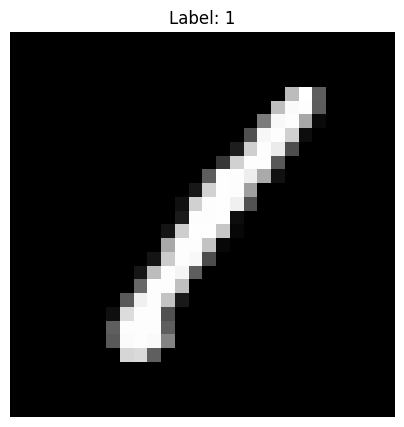

In [4]:
# Plotting some example images
def plot_image(pixel_array, actual=None):
    img = pixel_array.reshape(28, 28)
    plt.figure(figsize=(5, 5))
    if actual:
        plt.title(f"Label: {actual}")
    plt.imshow(img, cmap=plt.get_cmap("gray"))
    plt.axis("off")
    plt.show()

# Plot first image
plot_image(train_df.iloc[0, 1:].values, train_df.iloc[0, 0])

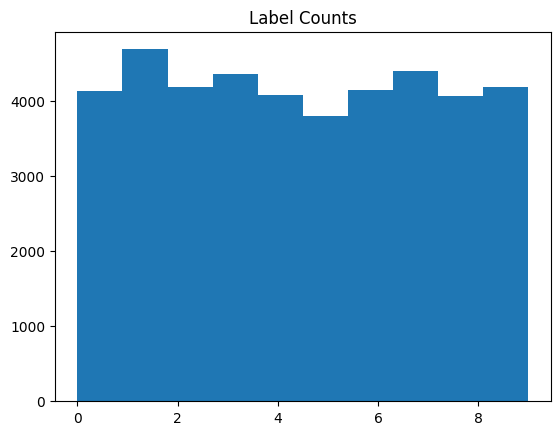

In [5]:
# Label distribution
plt.title("Label Counts")
plt.hist(train_df.iloc[:,0].values, bins=10)
plt.show()

The labels seem very evenly distributed and since the input data is already at different angles it is not necessary to rotate the input for better training. Nothing from the input data appears like there would be any outliers as this is a pretty clean dataset. 

# Model Creation

Model one will focus on using the Keras layer for Rescaling and the second model will use the normalization pre-processor to see which has a better results, be that faster training or better accuracy. Also to prevent overfitting Dropout layers will be used.

In [6]:
input_length = (784,1)
n_classes = 10
model_one_rescaling = models.Sequential(layers=(
    layers.Input(input_length),
    layers.Rescaling(1/255), # Scaling to make it between 0-1
    layers.Reshape((28, 28, 1)),
    layers.Conv2D(28, (3,3)), 
    layers.Conv2D(28, (3,3)),
    layers.MaxPooling2D(),
    layers.Conv2D(28, (3,3)),
    layers.Conv2D(28, (3,3)),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(100),
    layers.Dropout(0.15),
    layers.Dense(n_classes),
    layers.Activation("softmax"),
))

model_one_rescaling.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss=losses.CategoricalCrossentropy(),
    metrics=[
        metrics.CategoricalAccuracy(),
    ],
)

print(model_one_rescaling.summary())

# Fit/Train
history_model_one = model_one_rescaling.fit(X_train, y_train, epochs=15, validation_split=0.20)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 784, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 28)     │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 28)     │         7,084 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 12, 12, 28)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 10, 10, 28)     │         7,084 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 28)       │         7,084 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        44,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,442 (263.45 KB)

 Trainable params: 67,442 (263.45 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/15
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 38s 34ms/step - categorical_accuracy: 0.6967 - loss: 0.9786 - val_categorical_accuracy: 0.9393 - val_loss: 0.2126
Epoch 2/15
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 40s 33ms/step - categorical_accuracy: 0.9336 - loss: 0.2245 - val_categorical_accuracy: 0.9599 - val_loss: 0.1382
Epoch 3/15
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 34s 33ms/step - categorical_accuracy: 0.9557 - loss: 0.1507 - val_categorical_accuracy: 0.9670 - val_loss: 0.1091
Epoch 4/15
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 34s 33ms/step - categorical_accuracy: 0.9649 - loss: 0.1177 - val_categorical_accuracy: 0.9736 - val_loss: 0.0856
Epoch 5/15
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 34s 33ms/step - categorical_accuracy: 0.9701 - loss: 0.1005 - val_categorical_accuracy: 0.9738 - val_loss: 0.0835
Epoch 6/15
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 34s 33ms/step - categorical_accuracy: 0.9738 - loss: 0.0824 - val_categorical_accuracy: 0.9768 - val_loss: 0.0725
Epoch 7/15
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 34s 33ms/step - c

Now to train the second model with different scaling pre-processor.

In [7]:
model_two_normalization = models.Sequential(layers=(
    layers.Input(input_length),
    layers.Normalization(), # Center around zero
    layers.Reshape((28, 28, 1)),
    layers.Conv2D(28, (3,3)), 
    layers.Conv2D(28, (3,3)),
    layers.MaxPooling2D(),
    layers.Conv2D(28, (3,3)),
    layers.Conv2D(28, (3,3)),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(100),
    layers.Dropout(0.15),
    layers.Dense(n_classes),
    layers.Activation("softmax"),
))

model_two_normalization.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001),
    loss=losses.CategoricalCrossentropy(),
    metrics=[
        metrics.CategoricalAccuracy(),
    ],
)

print(model_two_normalization.summary())

# Fit/Train
history_model_two = model_two_normalization.fit(X_train, y_train, epochs=15, validation_split=0.20)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 784, 1)         │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 28)     │           280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 28)     │         7,084 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 28)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 10, 10, 28)     │         7,084 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 28)       │         7,084 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 28)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 448)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        44,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,445 (263.46 KB)

 Trainable params: 67,442 (263.45 KB)

 Non-trainable params: 3 (16.00 B)

None
Epoch 1/15
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 37s 34ms/step - categorical_accuracy: 0.6221 - loss: 10.4859 - val_categorical_accuracy: 0.9161 - val_loss: 0.8040
Epoch 2/15
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 35s 33ms/step - categorical_accuracy: 0.8978 - loss: 1.0300 - val_categorical_accuracy: 0.9399 - val_loss: 0.4821
Epoch 3/15
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - categorical_accuracy: 0.9275 - loss: 0.5696 - val_categorical_accuracy: 0.9524 - val_loss: 0.3043
Epoch 4/15
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 35s 33ms/step - categorical_accuracy: 0.9406 - loss: 0.4190 - val_categorical_accuracy: 0.9599 - val_loss: 0.2697
Epoch 5/15
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - categorical_accuracy: 0.9536 - loss: 0.2973 - val_categorical_accuracy: 0.9656 - val_loss: 0.1981
Epoch 6/15
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 35s 34ms/step - categorical_accuracy: 0.9586 - loss: 0.2321 - val_categorical_accuracy: 0.9658 - val_loss: 0.1860
Epoch 7/15
1050/1050 ━━━━━━━━━━━━━━━━━━━━ 35s 34ms/step - 

Looks like how the model is scaled does not make that big of a difference, but the graphs will help further show that.

Now to plot the loss and accuracy from the training history to see if there is a better epoch to look at.

In [8]:
print(history_model_two.history)

{'categorical_accuracy': [0.7707440257072449, 0.9043452143669128, 0.9283630847930908, 0.9431547522544861, 0.9533631205558777, 0.958184540271759, 0.9647023677825928, 0.9679166674613953, 0.9700595140457153, 0.9725595116615295, 0.9765178561210632, 0.9770833253860474, 0.9808035492897034, 0.9804762005805969, 0.9817261695861816], 'loss': [4.343984603881836, 0.9195051789283752, 0.5642310380935669, 0.39573073387145996, 0.2908867597579956, 0.23050056397914886, 0.18919780850410461, 0.160809725522995, 0.1389913707971573, 0.12344127893447876, 0.09914125502109528, 0.09581804275512695, 0.07724559307098389, 0.07608699053525925, 0.07607611268758774], 'val_categorical_accuracy': [0.9160714149475098, 0.9398809671401978, 0.9523809552192688, 0.9598809480667114, 0.9655952453613281, 0.965833306312561, 0.9695237874984741, 0.9703571200370789, 0.9698809385299683, 0.9730952382087708, 0.9735714197158813, 0.9742857217788696, 0.976190447807312, 0.9757142663002014, 0.9714285731315613], 'val_loss': [0.80404442548751

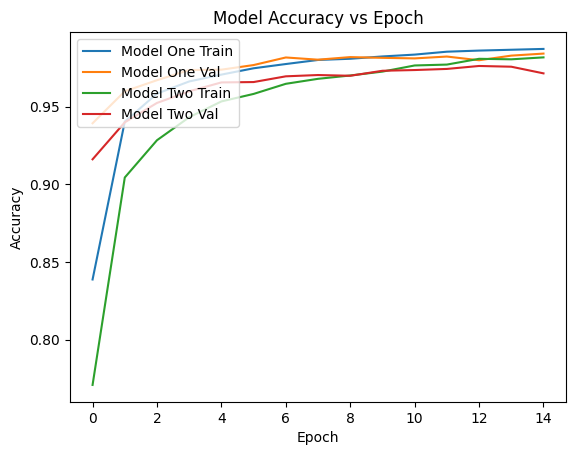

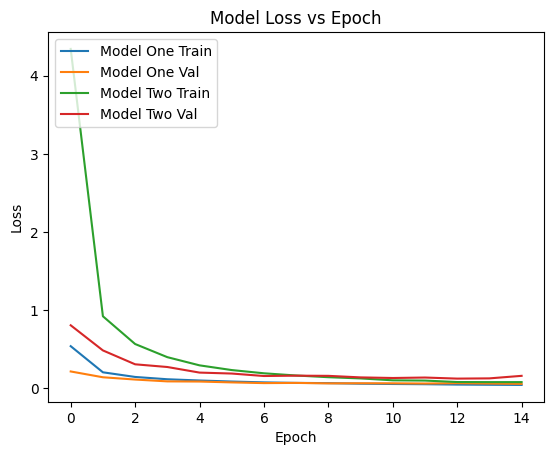

In [9]:
# Graphs for the previous models fit
# Accuracy
plt.plot(history_model_one.history["categorical_accuracy"])
plt.plot(history_model_one.history["val_categorical_accuracy"])
plt.plot(history_model_two.history["categorical_accuracy"])
plt.plot(history_model_two.history["val_categorical_accuracy"])
plt.title("Model Accuracy vs Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Model One Train", "Model One Val", "Model Two Train", "Model Two Val"], loc="upper left")
plt.show()

# Loss
plt.plot(history_model_one.history["loss"])
plt.plot(history_model_one.history["val_loss"])
plt.plot(history_model_two.history["loss"])
plt.plot(history_model_two.history["val_loss"])
plt.title("Model Loss vs Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Model One Train", "Model One Val", "Model Two Train", "Model Two Val"], loc="upper left")
plt.show()

# Conclusion and results

One issue that was run into immediately was using the `Accuracy` class instead of the `CategoricalAccuracy` which made it seem like the models were performing very poorly. So the initial assumption was that model two performed better than model one, but in reality they both were performing very well. Also it appears like even with the droppout layer there is sufficient to prevent overfitting with this structure. The CNN worked very well even just after two epochs and as seen both models performed well even though the normalization process was different, I had suspected that training times would differ and one of the mechanism was more efficient. A major limiting factor for this model is the input data must be 784 pixel long array and extra steps would need to be taken for the model to work for other sized input as well as multiple digits.

The following blocks are further analysis of the results and taking a look at what actually failed to match in the training data.


In [10]:
# Result submission
predictions_model_one = np.argmax(model_one_rescaling.predict(X_test), axis=1)
predictions_model_two = np.argmax(model_two_normalization.predict(X_test), axis=1)
pd.DataFrame({"ImageId": list(range(1, len(predictions_model_one) + 1)), "Label": predictions_model_two}).to_csv("submission.csv", index=False, header=True)


875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step
875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step


Predictions with model one


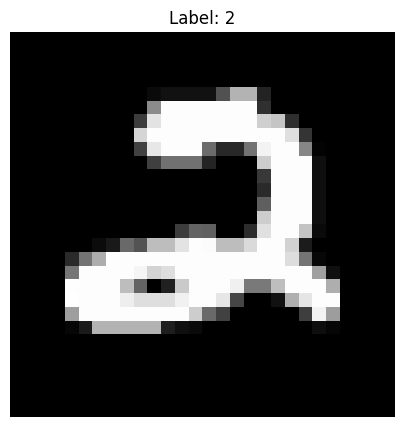

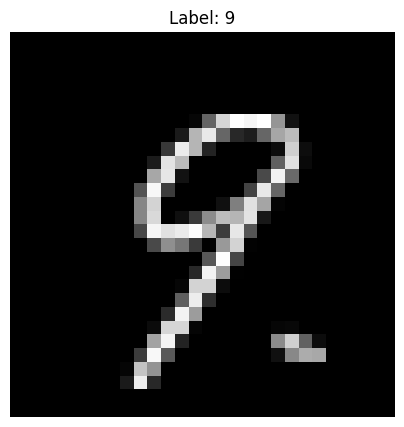

Predictions with model two


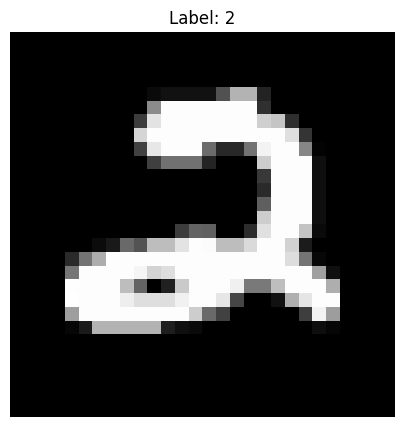

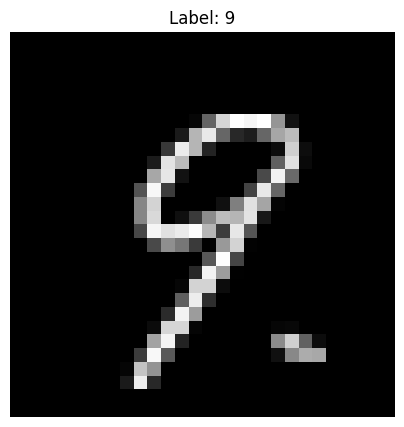

In [11]:
print("Predictions with model one")
plot_image(X_test[0], predictions_model_one[0])
plot_image(X_test[2], predictions_model_one[2])

# Plot image and suspected label
print("Predictions with model two")
plot_image(X_test[0], predictions_model_two[0])
plot_image(X_test[2], predictions_model_two[2])

Showing examples from the training that failed to label correctly.

In [12]:
# Run predictions on training samples
predictions_train_model_one = np.argmax(model_one_rescaling.predict(X_train), axis=1)
predictions_train_model_two = np.argmax(model_two_normalization.predict(X_train), axis=1)    

1313/1313 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step
1313/1313 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step


Model One
Actual: 9


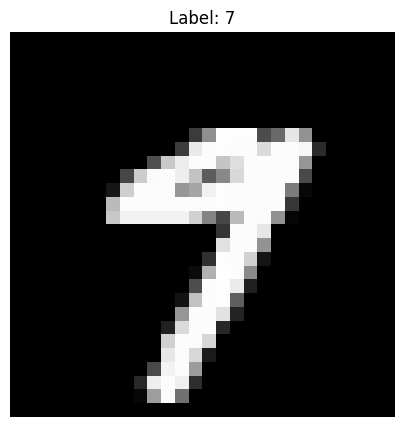

Model Two
Actual: 5


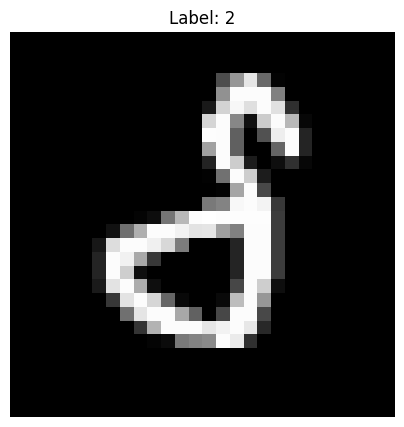

Model Two
Actual: 8


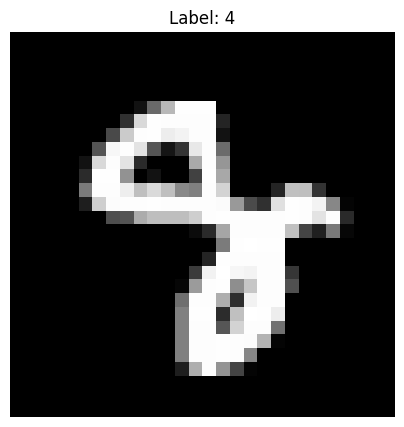

Model One
Actual: 4


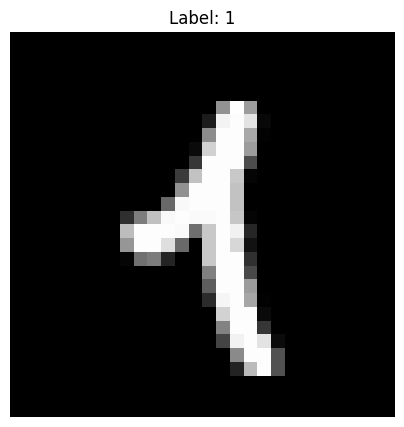

Model Two
Actual: 9


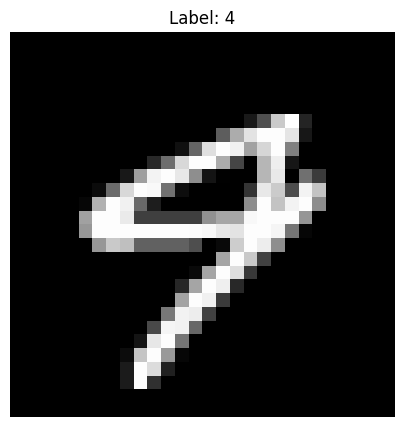

Model One
Actual: 2


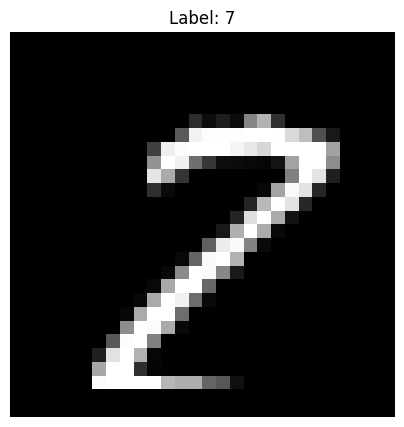

In [13]:
max_find = 3
pred_one_found = 0
pred_two_found = 0

for i in range(len(predictions_train_model_one)):
    img = X_train[i]
    actual_label = train_df.iloc[:,0].values[i]
    if pred_one_found < max_find and predictions_train_model_one[i] != actual_label:
        pred_one_found += 1
        print("Model One")
        print("Actual:", actual_label)
        plot_image(img, predictions_train_model_one[i])
    
    if pred_two_found < max_find and predictions_train_model_two[i] != actual_label:
        pred_two_found += 1
        print("Model Two")
        print("Actual:", actual_label)
        plot_image(img, predictions_train_model_two[i])

From those errors, I would also fail to identify some of those entries and the models did a good job of pulling out some good patterns and was still able to train and execute pretty quickly just on CPU.

Thank you for checking out my notebook :)